In [97]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
from scipy.ndimage import uniform_filter

In [98]:
def calculate_heat_load_index(dem_path, latitude):
    """
    Calculate the Heat Load Index (HLI) from a Digital Elevation Model (DEM).
    
    Parameters:
        dem_path (str): Path to the DEM file.
        latitude (float): Latitude of the area (in decimal degrees).
    
    Returns:
        hli_array (numpy.ndarray): 2D array of Heat Load Index values.
    """
    # Constants
    lat_radians = np.deg2rad(latitude)
    
    with rasterio.open(dem_path) as dem:
        # Read DEM data
        elevation = dem.read(1)
        
        # Get the resolution and crs of the DEM
        resolution = (dem.transform[0], dem.transform[4])
        bounds = dem.bounds
        crs = dem.crs
        
        # Calculate Slope and Aspect
        # Slope and aspect calculation using Sobel filter
        x, y = np.gradient(elevation, *resolution)
        
        # Ensure NA values propagate to slope
        slope = np.arctan(np.sqrt(x**2 + y**2))  # Slope in radians
        slope = np.where(np.isnan(elevation) | (elevation == 0.0), np.nan, slope)
        
        # Aspect: Angle in radians clockwise from north
        aspect = np.arctan2(-x, y)
        aspect = np.where(aspect < 0, 2 * np.pi + aspect, aspect)
        
        # Heat Load Index calculation
        hli = (
            0.339 + 
            0.808 * np.cos(lat_radians) * np.cos(slope) -
            0.196 * np.sin(lat_radians) * np.cos(slope) -
            0.482 * np.cos(aspect) * np.sin(slope) +
            0.266 * np.sin(aspect) * np.sin(slope)
        )
        
        # Set NoData values for invalid cells
        hli = np.where(np.isnan(elevation) | (elevation == 0.0), np.nan, hli)
    
    return slope, hli



def calculate_tpi(dem_path, neighborhood_size_meters):
    """
    Calculate Topographic Position Index (TPI) using a square neighborhood defined by half the side length in meters.
    
    Parameters:
        dem_path (str): Path to the DEM file
        neighborhood_size_meters (float): Half the side length of the neighborhood in meters
    """
    with rasterio.open(dem_path) as dem_raster:
        dem = dem_raster.read(1)
        
        # Get cell size in meters
        cell_size = abs(dem_raster.transform[0])  # Assuming square pixels
        
        # Convert half side length from meters to pixels
        half_side_length_pixels = int(round(neighborhood_size_meters / cell_size))
        
        # Create square kernel
        side_length_pixels = 2 * half_side_length_pixels + 1
        kernel = np.ones((side_length_pixels, side_length_pixels))
        print(f"Kernel dimensions: {kernel.shape}")
        n = kernel.sum()
        
        # Calculate mean elevation in the square neighborhood
        dem_sum = uniform_filter(dem, size=side_length_pixels) * n
        dem_count = uniform_filter(np.ones_like(dem), size=side_length_pixels) * n
        
        # Avoid division by zero
        mean_elevation = np.where(dem_count > 0, dem_sum / dem_count, np.nan)
        
        # Calculate TPI
        tpi = dem - mean_elevation

        tpi = np.where(np.isnan(dem) | (dem == 0.0), np.nan, tpi)

        return tpi

In [99]:
ned_path = 'data/raster/ned/ned.tif'
latitude = 46.8
terrain_dir = 'data/raster/terrain'
os.makedirs(terrain_dir, exist_ok=True)

dem = rasterio.open(ned_path)

slope, hli = calculate_heat_load_index(ned_path, latitude)

# Define NoData value as the minimum float value
nodata_value = np.finfo(np.float32).min  # Use np.float64 if higher precision is needed

# Update metadata to include NoData value
meta = dem.meta.copy()
meta.update(nodata=nodata_value)

# Save slope raster
slope_path = os.path.join(terrain_dir, 'slope.tif')
with rasterio.open(slope_path, 'w', **meta) as dst:
    slope = np.where(np.isnan(slope), nodata_value, slope)
    dst.write(slope, 1)

# Save heat load index raster 
hli_path = os.path.join(terrain_dir, 'hli.tif')
with rasterio.open(hli_path, 'w', **meta) as dst:
    hli = np.where(np.isnan(hli), nodata_value, hli)
    dst.write(hli, 1)

tpi_ngbs = [30, 60, 120, 240, 480, 960, 1920]

for ngb in tpi_ngbs:
    tpi = calculate_tpi(ned_path, ngb)
    tpi_path = os.path.join(terrain_dir, f'tpi_{ngb}.tif')
    with rasterio.open(tpi_path, 'w', **meta) as dst:
        tpi = np.where(np.isnan(tpi), nodata_value, tpi)
        dst.write(tpi, 1)

Kernel dimensions: (3, 3)
Kernel dimensions: (5, 5)
Kernel dimensions: (9, 9)
Kernel dimensions: (17, 17)
Kernel dimensions: (33, 33)
Kernel dimensions: (65, 65)
Kernel dimensions: (129, 129)


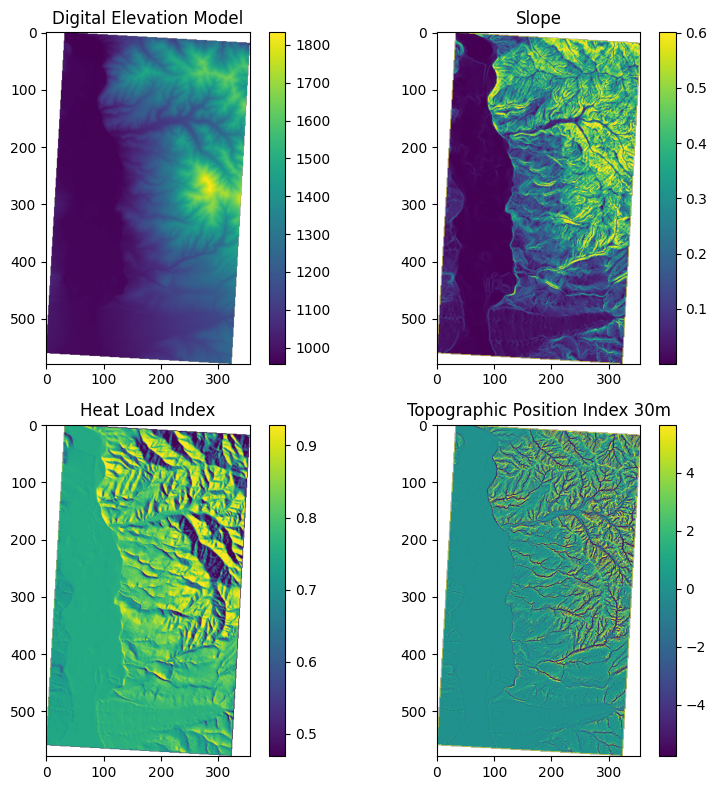

In [104]:
def get_vmin_vmax(masked_array):
    vmin = np.percentile(masked_array.compressed(), 2.5)
    vmax = np.percentile(masked_array.compressed(), 97.5)
    return vmin, vmax

focal_tpi_ngb = 30

# Load DEM and terrain predictors
dem = rasterio.open(ned_path).read(1)
slope = rasterio.open(os.path.join(terrain_dir, 'slope.tif')).read(1)
hli = rasterio.open(os.path.join(terrain_dir, 'hli.tif')).read(1)
tpi = rasterio.open(os.path.join(terrain_dir, f'tpi_{focal_tpi_ngb}.tif')).read(1)

# Create masks for NA values
dem_mask = dem == 0.0
slope_mask = slope == nodata_value
hli_mask = hli == nodata_value
tpi_mask = tpi == nodata_value

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

dem_masked = np.ma.masked_array(dem, dem_mask)
im1 = axes[0].imshow(dem_masked)
axes[0].set_title('Digital Elevation Model')
plt.colorbar(im1, ax=axes[0])

slope_masked = np.ma.masked_array(slope, slope_mask)
vmin, vmax = get_vmin_vmax(slope_masked)
im2 = axes[1].imshow(slope_masked, vmin=vmin, vmax=vmax)
axes[1].set_title('Slope')
plt.colorbar(im2, ax=axes[1])

hli_masked = np.ma.masked_array(hli, hli_mask)
vmin, vmax = get_vmin_vmax(hli_masked)
im3 = axes[2].imshow(hli_masked, vmin=vmin, vmax=vmax)
axes[2].set_title('Heat Load Index')
plt.colorbar(im3, ax=axes[2])

tpi_masked = np.ma.masked_array(tpi, tpi_mask)
vmin, vmax = get_vmin_vmax(tpi_masked)
im4 = axes[3].imshow(tpi_masked, vmin=vmin, vmax=vmax)
axes[3].set_title(f'Topographic Position Index {focal_tpi_ngb}m')
plt.colorbar(im4, ax=axes[3])

plt.tight_layout()
plt.show()


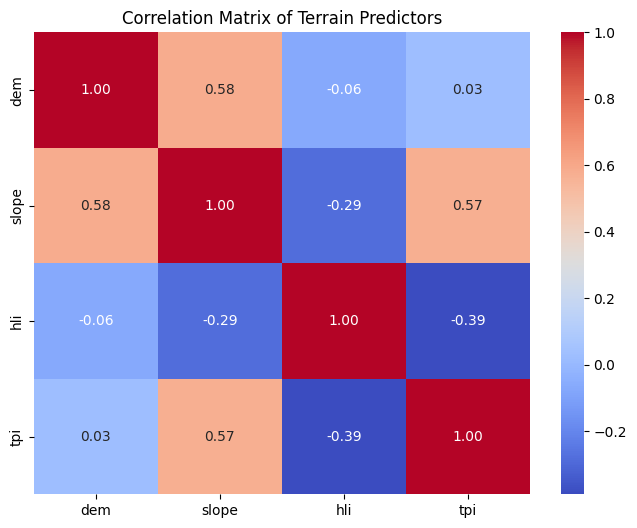

In [106]:
# Stack the masked arrays, remove masked values, and convert to dataframe
data = np.stack([dem_masked.compressed(), slope_masked.compressed(), hli_masked.compressed(), tpi_masked.compressed()], axis=1)
df = pd.DataFrame(data, columns=['dem', 'slope', 'hli', 'tpi'])

# Generate the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Terrain Predictors')
plt.show()